In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/Colab_Notebooks/spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!mv spark-3.5.1-bin-hadoop3 /content/

'sudo' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.
tar: Error opening archive: Failed to open '/content/drive/MyDrive/Colab_Notebooks/spark-3.5.1-bin-hadoop3.tgz'


'mv' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [4]:
import findspark
findspark.init()
findspark.find()
import pyspark as spark
print(spark.__version__)

3.5.1


In [5]:
from pyspark.sql import SparkSession, DataFrame, functions as F, Column
from pyspark.sql.functions import to_date, col, lag, asc, round
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import FloatType
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext, SparkConf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession.builder \
    .appName("Final") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# **Task 1**

In [ ]:
data = '/content/drive/MyDrive/Colab_Notebooks/mnist_mini.csv'
df = spark.read.csv(data, header=False, inferSchema=True)
df.show()

In [ ]:
class Clustering:
    def __init__(self, spark: SparkSession, data_path: str):
        self.spark = spark
        self.df = self.prepare_data(data_path)

    def prepare_data(self, data_path: str, weighted_indices: list = [], weight_factor: int = 100) -> DataFrame:
        df = self.spark.read.csv(data_path, header=False, inferSchema=True)
        df = df.withColumnRenamed("_c0", "label")

        if weighted_indices:
            df = df.withColumn(
                "weight",
                F.when(F.col("label").isin(weighted_indices), weight_factor)
                .otherwise(1)
                .cast("double"),
            )
        else:
            df = df.withColumn("weight", F.lit(1.0))

        assembler = VectorAssembler(
            inputCols=df.columns[1:-1], outputCol="features"  # Exclude label and weight
        )
        df = assembler.transform(df)

        scaler = StandardScaler(
            inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False
        )
        scalerModel = scaler.fit(df)
        df = scalerModel.transform(df)
        return df

    def cluster(self, k: int, seed: int = 42):
        kmeans = KMeans(
            featuresCol="scaledFeatures", k=k, seed=seed, weightCol="weight"
        )
        model = kmeans.fit(self.df)
        return model, model.transform(self.df).select("label", "prediction", "scaledFeatures")

    def calculate_average_distances(self, model, transformed_df: DataFrame) -> list:
        avg_distances = []
        for cluster in range(k):
            cluster_data = (
                transformed_df.filter(F.col("prediction") == cluster)
                .select("scaledFeatures")
                .rdd.map(lambda row: Vectors.dense(row["scaledFeatures"]))
                .collect()
            )
            centroid = Vectors.dense(model.clusterCenters()[cluster])
            distances = [Vectors.squared_distance(point, centroid) for point in cluster_data]
            avg_dist = sum(distances) / len(distances)
            avg_distances.append(avg_dist)
        return avg_distances

    def visualize_distances(self, avg_distances: list):
        plt.bar(range(len(avg_distances)), avg_distances)
        plt.xlabel("Cluster")
        plt.ylabel("Average Distance to Centroid")
        plt.title("Average Distances to Centroids for Each Cluster")
        plt.show()

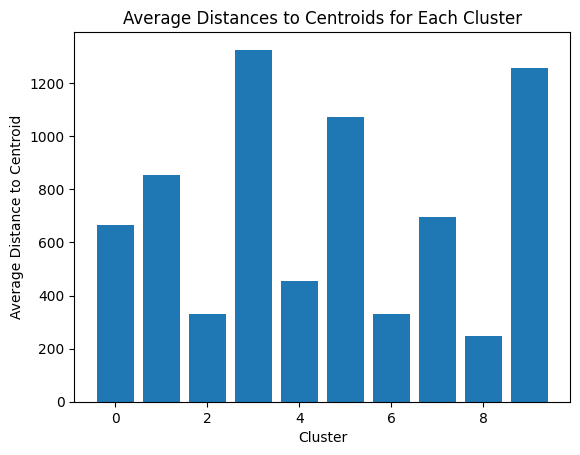

In [ ]:
clusterer = Clustering(spark, data)
weighted_indices = [0, 1, 2, 3, 4, 7, 8, 11, 18, 61]
k = 10

model, transformed_df = clusterer.cluster(k)
avg_distances = clusterer.calculate_average_distances(model, transformed_df)
clusterer.visualize_distances(avg_distances)

##**Task 2**

In [ ]:
import random
from pyspark.mllib.linalg.distributed import RowMatrix, IndexedRow, IndexedRowMatrix
from pyspark.ml.linalg import DenseMatrix

In [ ]:
class SVDReducer:
    def __init__(self, file_path, label_col="_c0", n_components=3, sample_size=100):
        self.file_path = file_path
        self.n_components = n_components
        self.sample_size = sample_size
        self.spark = SparkSession.builder.appName("DimensionalityReducer").getOrCreate()
        self.data = None
        self.reduced_data = None
        self.label_with_index = None


    def load_data(self):
        self.data = self.spark.read.csv(self.file_path, header=False, inferSchema=True)


    def preprocess_data(self):
        data_with_index = self.data.rdd\
                    .map(lambda x: (x[0],\
                                    Vectors.dense([float(it) for it in x[1:]])))\
                    .zipWithIndex()\
                    .map(lambda x: (x[1], x[0][0], x[0][1]))\
                    .toDF(["id", "label", "features"])
        self.label_with_index = data_with_index.select("id", "label")

        feature_with_index = data_with_index.select("id", "features").rdd\
                    .map(lambda row: IndexedRow(row["id"], row["features"].tolist()))

        return feature_with_index


    def cal_SVD(self, indexed_row_rdd, r=3):
        index_row_matrix = IndexedRowMatrix(indexed_row_rdd)
        svd = index_row_matrix.computeSVD(r, True)
        U = svd.U.rows.collect()
        S = svd.s.toArray()
        V = svd.V
        return U, S, V

    def reduce_dimensionality(self):
        indexed_row_rdd = self.preprocess_data()
        U, S, V = self.cal_SVD(indexed_row_rdd)
        self.reduced_data = np.array([u.vector.toArray()[:self.n_components] for u in U])

    def get_random_samples(self):
        if self.reduced_data is None:
            raise ValueError("No reduced data available. Run reduce_dimensionality first.")

        indices = np.random.choice(len(self.reduced_data), size=self.sample_size, replace=False)
        return self.reduced_data[indices]

    def plot_samples(self, samples):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c='b', marker='o')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        plt.show()


    def run(self):
        self.load_data()
        self.reduce_dimensionality()
        samples = self.get_random_samples()
        self.plot_samples(samples)


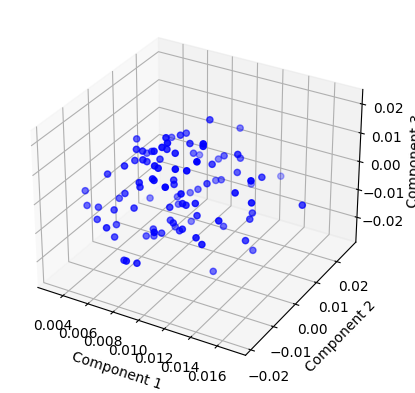

In [ ]:
input_file = "/content/drive/MyDrive/Colab_Notebooks/mnist_mini.csv"

reducer = SVDReducer(input_file)
reducer.run()

# **Task 3**

In [ ]:
class CollaborativeFiltering:
    def __init__(self, data_path, rank_range):
        self.spark = SparkSession.builder.appName("CollaborativeFiltering").getOrCreate()
        self.data_path = data_path
        self.rank_range = rank_range
        self.data = None
        self.train_data = None
        self.test_data = None
        self.model = None

    def load_data(self):
        print("Loading data...")
        self.data = self.spark.read.csv(self.data_path, header=True, inferSchema=True)

    def preprocess_data(self, train_fraction=0.7):
        print("Splitting data into training and test sets...")
        (self.train_data, self.test_data) = self.data.randomSplit([train_fraction, 1 - train_fraction])
        print(f"Training data count: {self.train_data.count()}, Test data count: {self.test_data.count()}")

    def build_model(self, rank, maxIter=10, regParam=0.1):
        print(f"Building model with rank: {rank}...")
        als = ALS(maxIter=maxIter, regParam=regParam, rank=rank, userCol="user", itemCol="item", ratingCol="rating", coldStartStrategy="drop")
        self.model = als.fit(self.train_data)

    def evaluate_model(self):
        print("Evaluating model...")
        predictions = self.model.transform(self.test_data)
        evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
        mse = evaluator.evaluate(predictions)
        print(f"Evaluation completed with MSE: {mse}")
        return mse

    def run(self):
        self.load_data()
        self.preprocess_data()
        mse_values = []
        for rank in self.rank_range:
            self.build_model(rank=rank)
            mse = self.evaluate_model()
            mse_values.append(mse)
            print(f"Rank: {rank}, MSE: {mse}")
        self.visualize_results(self.rank_range, mse_values)

    def visualize_results(self, rank_range, mse_values):
        plt.bar(rank_range, mse_values)
        plt.xlabel('Number of Latent Factors (Rank)')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.title('Correlation between MSE and Number of Latent Factors')
        plt.show()

Loading data...
Splitting data into training and test sets...
Training data count: 1669, Test data count: 696
Building model with rank: 10...
Evaluating model...
Evaluation completed with MSE: 1.2662359635411782
Rank: 10, MSE: 1.2662359635411782
Building model with rank: 11...
Evaluating model...
Evaluation completed with MSE: 1.2048789544703244
Rank: 11, MSE: 1.2048789544703244
Building model with rank: 12...
Evaluating model...
Evaluation completed with MSE: 1.217901262169418
Rank: 12, MSE: 1.217901262169418
Building model with rank: 13...
Evaluating model...
Evaluation completed with MSE: 1.252243742051413
Rank: 13, MSE: 1.252243742051413
Building model with rank: 14...
Evaluating model...
Evaluation completed with MSE: 1.2130647516116528
Rank: 14, MSE: 1.2130647516116528
Building model with rank: 15...
Evaluating model...
Evaluation completed with MSE: 1.2940607885065865
Rank: 15, MSE: 1.2940607885065865
Building model with rank: 16...
Evaluating model...
Evaluation completed with 

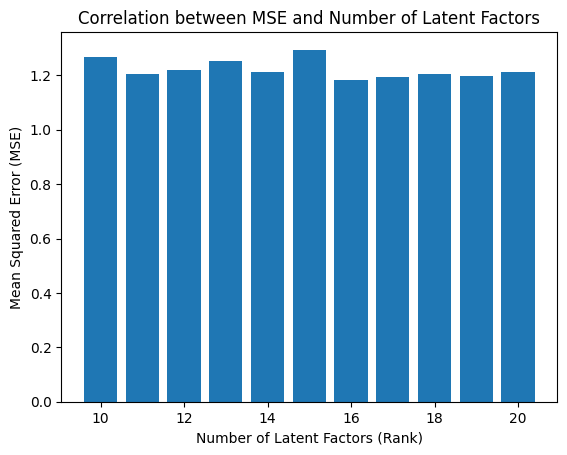

In [ ]:
data_path = '/content/drive/MyDrive/Colab_Notebooks/ratings2k.csv'
rank_range = range(10, 21)
recommender = CollaborativeFiltering(data_path, rank_range)
recommender.run()

# **Task 4**

In [7]:
class StockDataProcessor:
    def __init__(self):
        self.spark = SparkSession.builder\
                                 .appName("StockPriceFluctuationRangePrediction")\
                                 .getOrCreate()
        self.df = None

    def load_data(self, file_path):
        self.df = self.spark.read.csv(file_path, header=True, inferSchema=True)
        ## Change suitablely default formate datetime for dataset
        self.df = self.df.withColumn("Ngay", to_date(col("Ngay"), "dd/MM/yyy"))
        ## Change stock price column to be numerical
        self.df = self.df.withColumn("HVN", col("HVN").cast("float"))
        ## Sort dates in ascending order
        self.df = self.df.orderBy(asc("Ngay"))
        return self.df

    def prepare_data(self, dataset):
        prepared_dataset = None
        windowSpec = Window.orderBy("Ngay")
        ## Create fluctuation column
        dataset = dataset.withColumn('fluctuation', (col('HVN') - lag('HVN', 1).over(windowSpec)) \
                                                        / lag('HVN', 1).over(windowSpec))
        dataset = dataset.na.fill({'fluctuation': 0})

        ## Get ranges of 5 previous dates
        for i in range(1, 6):
            dataset = dataset.withColumn(f'ranges_of_{i}_prev_dates', lag('fluctuation', i).over(windowSpec))
        dataset = dataset.dropna()

        ## Combine ranges of 5 previous dates to one column
        assembler = VectorAssembler(inputCols=[f'ranges_of_{i}_prev_dates' for i in range(1, 6)], outputCol='features')
        prepared_dataset = assembler.transform(dataset).select('Ngay', 'features', col('fluctuation').alias('label'))

        return prepared_dataset

    def split_data(self):
        train_data = self.df.filter(self.df['Ngay'] <= '2022-06-30')
        test_data = self.df.filter(self.df['Ngay'] > '2022-06-30')
        return train_data, test_data

In [9]:
processor = StockDataProcessor()
df = processor.load_data("/content/drive/MyDrive/Colab_Notebooks/stockHVN2022.csv")
train_data, test_data = processor.split_data()
processor.prepare_data(train_data).take(5)

[Row(Ngay=datetime.date(2022, 1, 11), features=DenseVector([0.0243, -0.0088, -0.0108, -0.0086, 0.0]), label=-0.006465582799399054),
 Row(Ngay=datetime.date(2022, 1, 12), features=DenseVector([-0.0065, 0.0243, -0.0088, -0.0108, -0.0086]), label=-0.004338328738870972),
 Row(Ngay=datetime.date(2022, 1, 13), features=DenseVector([-0.0043, -0.0065, 0.0243, -0.0088, -0.0108]), label=-0.013071944855602494),
 Row(Ngay=datetime.date(2022, 1, 14), features=DenseVector([-0.0131, -0.0043, -0.0065, 0.0243, -0.0088]), label=0.002207556081734901),
 Row(Ngay=datetime.date(2022, 1, 17), features=DenseVector([0.0022, -0.0131, -0.0043, -0.0065, 0.0243]), label=0.008810521976604648)]

In [10]:
class StockFlucModel:
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        self.model = None
        self.evaluator = RegressionEvaluator(metricName="mse")

    def train_model(self):
        lr = LinearRegression(featuresCol='features', labelCol='label')
        self.model = lr.fit(self.train_data)
        return self.model

    def evaluate_model(self):
        train_predictions = self.model.transform(self.train_data)
        test_predictions = self.model.transform(self.test_data)
        train_mse = self.evaluator.evaluate(train_predictions)
        test_mse = self.evaluator.evaluate(test_predictions)
        return train_mse, test_mse

    def predict(self):
        predictions = self.model.transform(self.test_data)
        return predictions.select('prediction')

    def plot_mse(self, train_mse, test_mse):
        plt.bar(['Train MSE', 'Test MSE'], [train_mse, test_mse], color=['blue', 'orange'])
        plt.ylabel('Mean Square Error')
        plt.title('MSE for Train and Test Sets')
        plt.show()

Samples of dataset: 
+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|2022-01-04| 23.3|
|2022-01-05| 23.1|
|2022-01-06|22.85|
|2022-01-07|22.65|
|2022-01-10| 23.2|
+----------+-----+
only showing top 5 rows

The number of rows of dataset:  219
Columns of dataset: 
root
 |-- Ngay: date (nullable = true)
 |-- HVN: float (nullable = true)



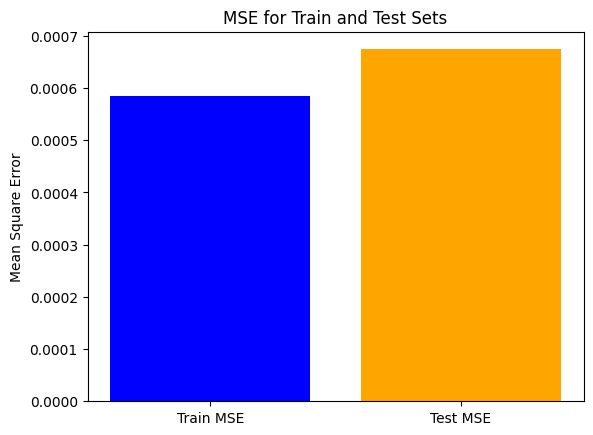

+--------------------+
|          prediction|
+--------------------+
|-0.00337246015779...|
|-6.40023528657115E-4|
|-0.00951425708381701|
|-5.47631591134960...|
|0.003675510125960...|
+--------------------+
only showing top 5 rows



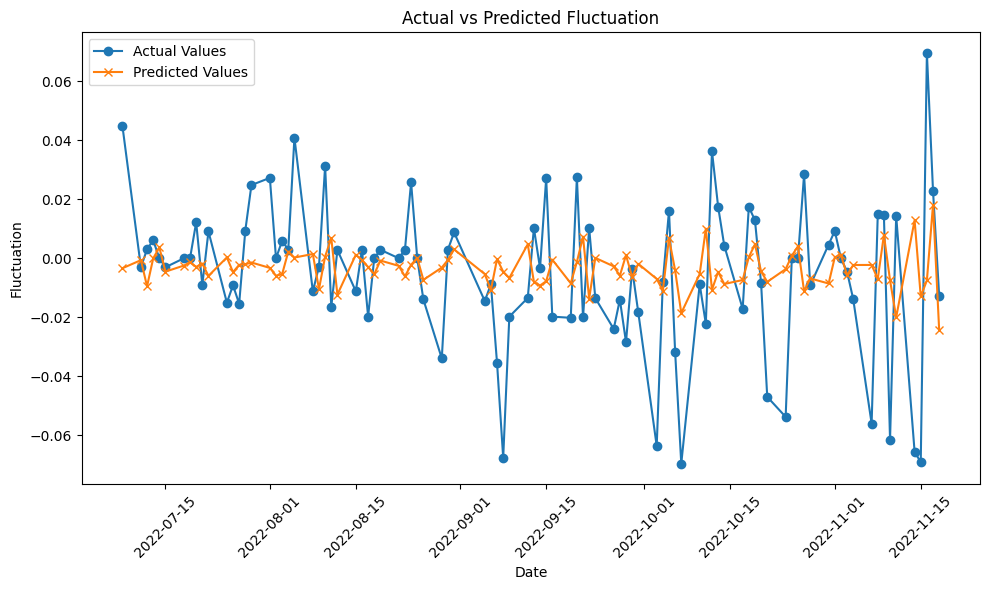

In [12]:
def main():
    ## Load and prepare data
    processor = StockDataProcessor()
    data = processor.load_data('/content/drive/MyDrive/Colab_Notebooks/stockHVN2022.csv')

    print("Samples of dataset: ")
    data.show(5)
    print("The number of rows of dataset: ", data.count())
    print("Columns of dataset: ")
    data.printSchema()

    train_data, test_data = processor.split_data()
    prepared_train_data = processor.prepare_data(train_data)
    prepared_test_data = processor.prepare_data(test_data)

    ## Create, train, evaluate and visulize results of model
    model = StockFlucModel(prepared_train_data, prepared_test_data)
    model.train_model()
    train_mse, test_mse = model.evaluate_model()
    model.plot_mse(train_mse, test_mse)

    # Predict on the test set
    predictions = model.predict()
    predictions.show(5)

    # Collect actual and predicted values along with dates
    actual_values = [row['label'] for row in prepared_test_data.collect()]
    predicted_values = [row['prediction'] for row in predictions.collect()]
    dates = [row['Ngay'] for row in prepared_test_data.collect()]

    # Plot actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(dates, actual_values, label='Actual Values', marker='o')
    plt.plot(dates, predicted_values, label='Predicted Values', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Fluctuation')
    plt.title('Actual vs Predicted Fluctuation')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


# **Task 5**

In [ ]:
class MultiClassClassification:
    def __init__(self, input_path):
        self.spark = SparkSession.builder \
            .appName("MultiClassClassification") \
            .config("spark.driver.memory", "8g") \
            .config("spark.executor.memory", "8g") \
            .getOrCreate()
        self.data = self.spark.read.csv(input_path, header=False, inferSchema=True)
        self.rename_columns()
        self.train_data, self.test_data = None, None

    def rename_columns(self):
        # Efficiently rename columns
        new_column_names = ["label"] + [f"pixel{i}" for i in range(784)]
        self.data = self.data.toDF(*new_column_names)

    def preprocess_data(self):
        feature_cols = [f"pixel{i}" for i in range(784)]
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        assembled_data = assembler.transform(self.data).select("label", "features")
        self.train_data, self.test_data = assembled_data.randomSplit([0.8, 0.2], seed=1234)

    def train_evaluate(self, model):
        model = model.fit(self.train_data)
        predictions_train = model.transform(self.train_data)
        predictions_test = model.transform(self.test_data)

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy_train = evaluator.evaluate(predictions_train)
        accuracy_test = evaluator.evaluate(predictions_test)

        return accuracy_train, accuracy_test

    def run_classifiers(self):
        results = {}

        # Multi-layer Perceptron
        layers = [784, 128, 64, 10]
        mlp = MultilayerPerceptronClassifier(layers=layers, labelCol="label", featuresCol="features", maxIter=100)
        results['MLP'] = self.train_evaluate(mlp)

        # Random Forest
        rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
        results['RandomForest'] = self.train_evaluate(rf)

        # One-vs-Rest with Linear SVM
        lsvc = LinearSVC(labelCol="label", featuresCol="features", maxIter=100)
        ovr = OneVsRest(classifier=lsvc)
        results['OneVsRest_LinearSVM'] = self.train_evaluate(ovr)

        return results

    def plot_results(self, results):
        models = list(results.keys())
        accuracies_train = [results[model][0] for model in models]
        accuracies_test = [results[model][1] for model in models]

        x = range(len(models))

        fig, ax = plt.subplots()
        bar_width = 0.35

        bars1 = ax.bar(x, accuracies_train, bar_width, label='Train Accuracy')
        bars2 = ax.bar([p + bar_width for p in x], accuracies_test, bar_width, label='Test Accuracy')

        ax.set_xlabel('Model')
        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy by Model and Dataset')
        ax.set_xticks([p + bar_width / 2 for p in x])
        ax.set_xticklabels(models)
        ax.legend(loc='lower right')

        plt.show()

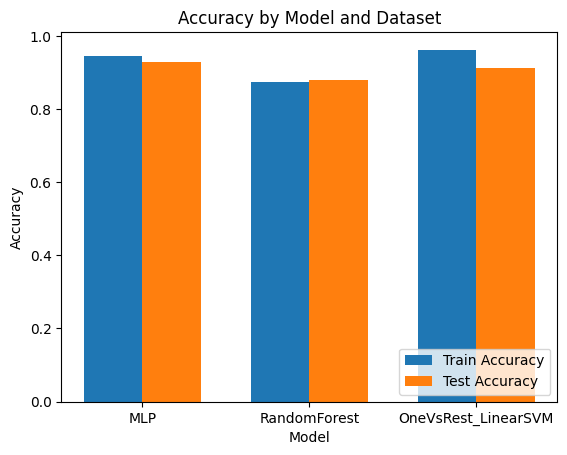

In [ ]:
classification = MultiClassClassification("/content/drive/MyDrive/Colab_Notebooks/mnist_mini.csv")
classification.preprocess_data()
results = classification.run_classifiers()
classification.plot_results(results)